# CanSat Rejoin Example

This Jupyter notebook demonstrates a multi-agent task scenario modeled with control system analysis framework (CSAF), where a group of satellites attempt to rejoin in formation while avoiding collision with one another.  The spacecraft model was taken from the [AerospaceRL repository on GitHub](https://github.com/act3-ace/aerospaceRL). The simple 2D model uses applied forces to move a satellite
agent around on a plane. The coordinate system is relative to a "chief" satellite, where chaser satellites are attempting to
approach the chief without crashing into it. To create a multi-agent example, four chaser satellites were instantiated around the chief, who attempt to
approach the chief satellite without crashing into one another.

The model has a 4D state space, $(x,y)$ position and $(\dot x, \dot y)$ velocities. The input space consists of two applied forces,
$\mathbf{F} = (F_x, F_y)^T$. The state evolution function can be written
as

$$
\dot{\mathbf{x}} = \begin{bmatrix} x_2 \\
 x_3 \\
3 n^2 x_0 + 2 n x_3 + \frac{1}{m_c} F_x\\
-2 n x_2 + \frac{1}{m_c} F_y \end{bmatrix},
$$

where $\mathbf{x}=(x, y, \dot x, \dot y)$, $n$ is the mean motion, and $m_c$ is the mass of the chaser. In linear state space form,

$$
\dot{\mathbf{x}} = \begin{bmatrix} 0 && 0 && 1 && 0 \\
 0 && 0 && 0 && 1 \\
3 n^2 && 0 && 0 && 2 n \\
0 && 0 && -2 n && 0 \end{bmatrix} \mathbf{x} +
\begin{bmatrix}
0 && 0 \\
0 && 0 \\
\frac{1}{m_c} && 0 \\
0 && \frac{1}{m_c} \\
\end{bmatrix} \mathbf{F}.
$$

  
  
## Controller Design

A controller policy is designed to achieve the multi-agent goal, responsible for supplying the forces to all satellites. While the original AerospaceRL benchmark scenario was meant for
RL, a simple spring system approach is taken. The input force for each element can be accomplished in three steps:

1.  Construct an undirected graph $\mathcal G$ of satellites $\mathcal S$ and connections $\mathcal C$ to nearby satellites,
$$
\mathcal G = (\mathcal S, \mathcal C).
$$
    Any satellite $s_i$ has a set of neighbors, $\text{neighbors} \subseteq \mathcal S$, being all satellites with which $s_i$ has connections.
2.  Construct a damped spring system by assigning a spring and damping constant to each connection.
3.  Solve for the force applied to each node, and use that as a control policy for each satellite. For satellite $s_i$,
    the force $F_i$ applied to the input would be a sum of the forces supplied by neighbors,  
$$
\mathbf{F_i} = \sum_{s_j \in \text{neighbors}} k_p (||\mathbf r||_2 - r_l) + k_d || \operatorname{proj}_{\hat{\mathbf r}} (\mathbf v_r)||_2,
$$
    where $\mathbf r = {\mathbf x_{j,:2} -\mathbf  x_{i,:2}}$, $\mathbf v_r = {\mathbf x_{j, 2:} - \mathbf x_{i, 2:}}$, $r_l$ is the spring rest length,
    $k_p$ is the spring constant, and $k_d$ is the damping factor. The rest length in this case defines the ideal final distances that
    all satellites should have to one another.

Also, this technique can be done in a centralized or distributed fashion. Notably, should all satellites be able to detect one another
symmetrically, step (1) can be accomplished per satellite by $\epsilon$-ball construction. If the satellites cannot agree who is a valid connection,
the graph becomes directed, and the controller no longer represents a spring system.



In [1]:
# if running locally
import sys
sys.path.append("..")

# import csaf and CanSat example model
import csaf
import csaf.utils as csafutils
import csaf_examples.cansat as canm

# other imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from scipy.spatial.qhull import Delaunay

## Configuration

The CanSat system can be created via the `generate_cansat_system` function by passing in a list of chasers' initial states. A controller is created dynamically to support the number of chasers specified with the states list. This system component topology can be viewed via the `view_block_diagram` utility function.


In [2]:
# chaser initial states (pos + vel)
sat_states = [[10, -10, -2.0, 2.1], 
            [10, -7, 0.7, 0.0], 
            [-12, -7, -0.3, 1.0],
            [10, 0, -0.2, .1],
             [5, 5, .4, -0.2],
             [-5, 1, 0.0, 0.0]]

system = canm.generate_cansat_system(sat_states)

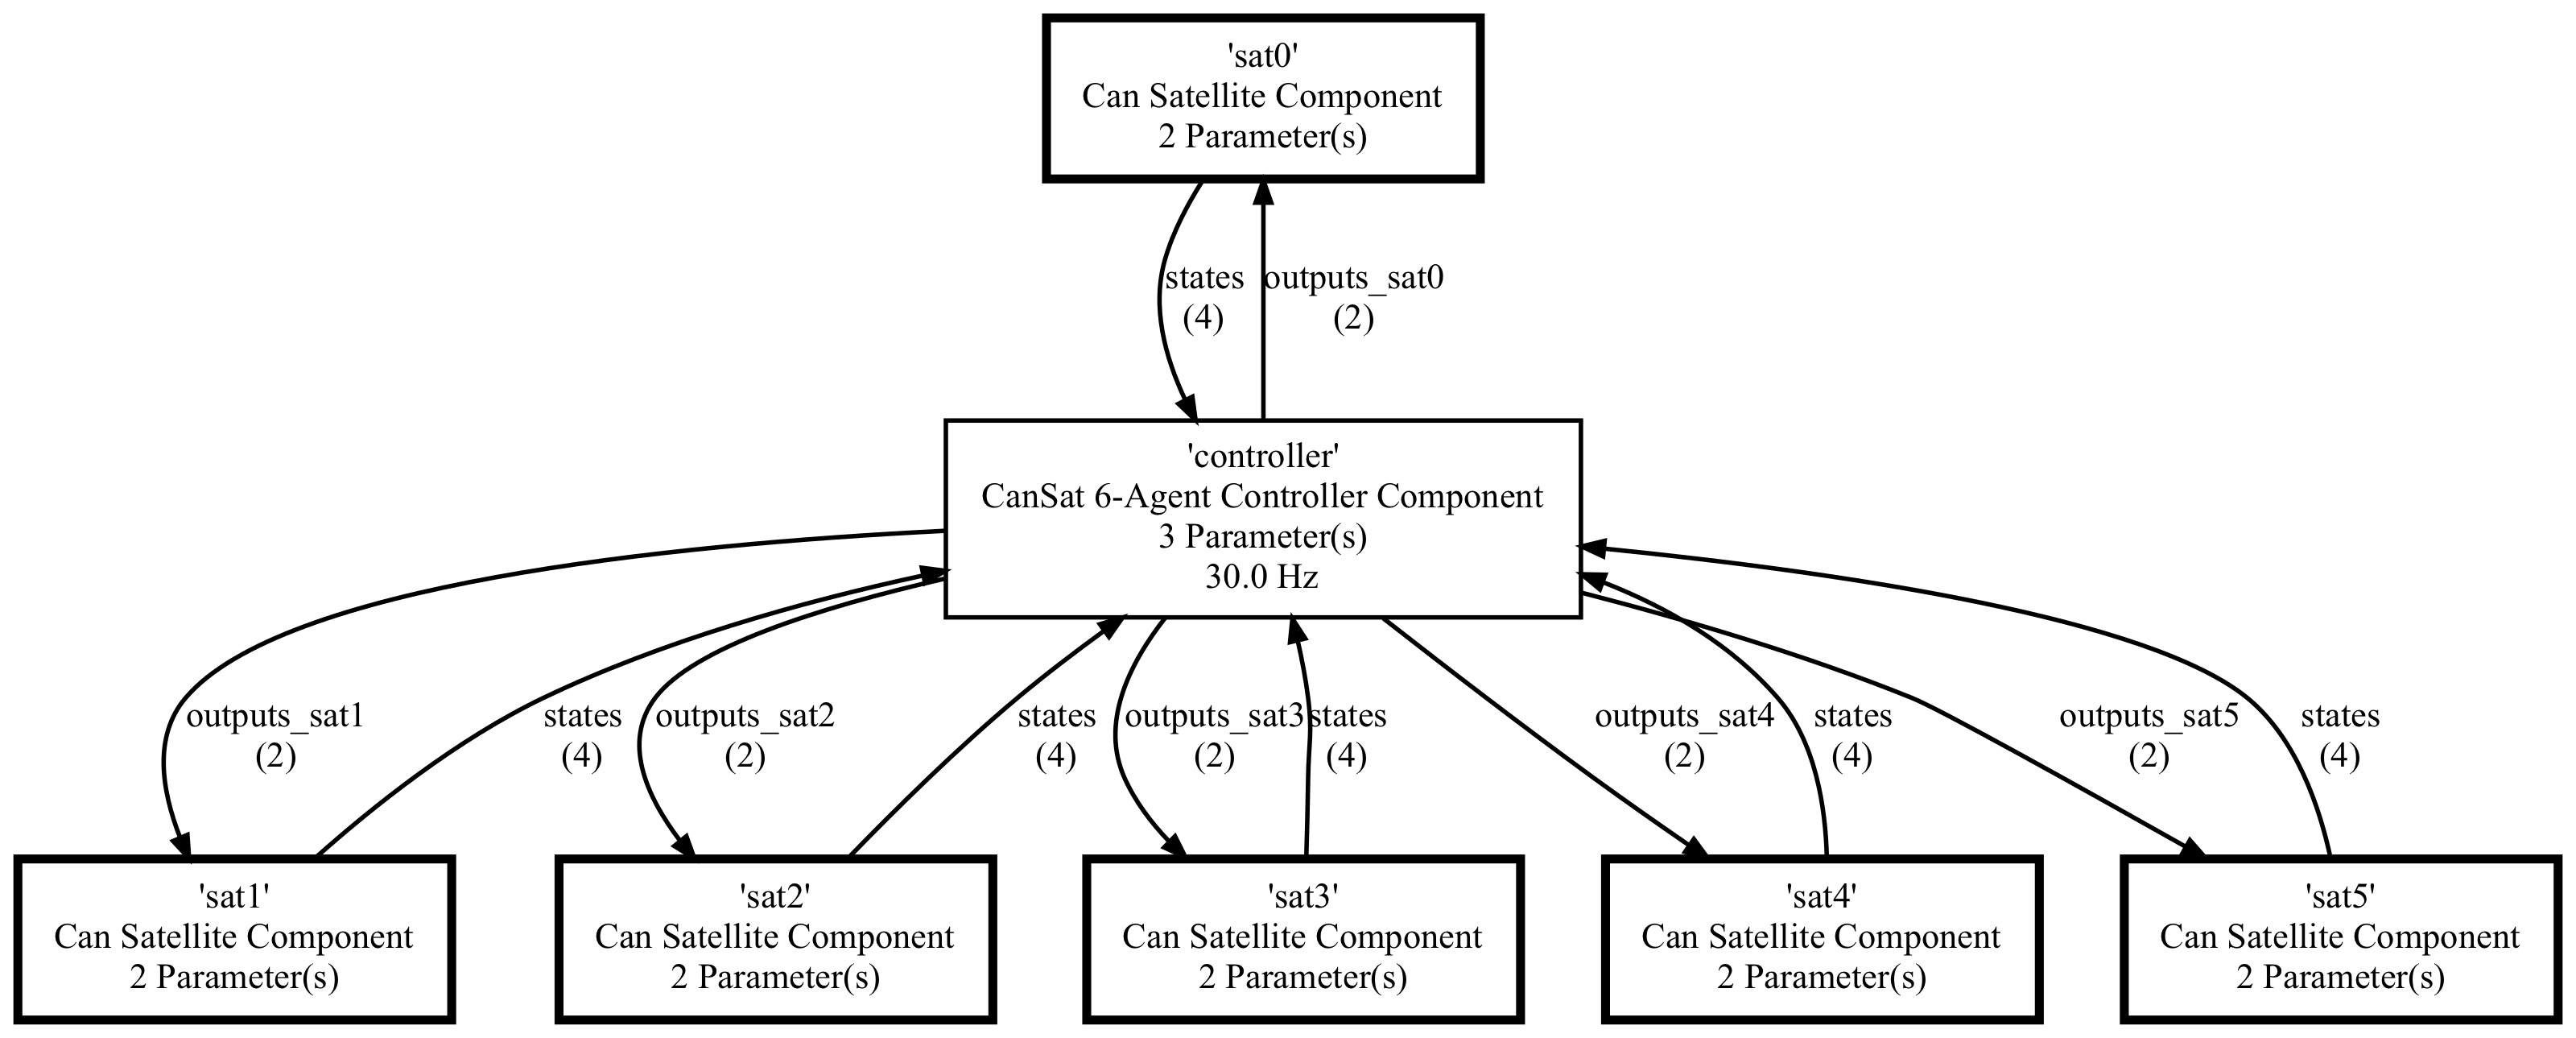

In [3]:
# view the system
csafutils.view_block_diagram(system, ipython_notebook=True)

## Simulation

After configuration, the CSAF system is simulated via the method `System.simulate_tspan`. The returned traces `trajs` capture the trajectories of each agent as the controller applies the forces.

In [4]:
trajs = system.simulate_tspan((0.0, 25.0))

In [5]:
# pack states into convenient data structure
states = [np.array(trajs['sat'+str(idx)].states) for idx in range(len(sat_states))]

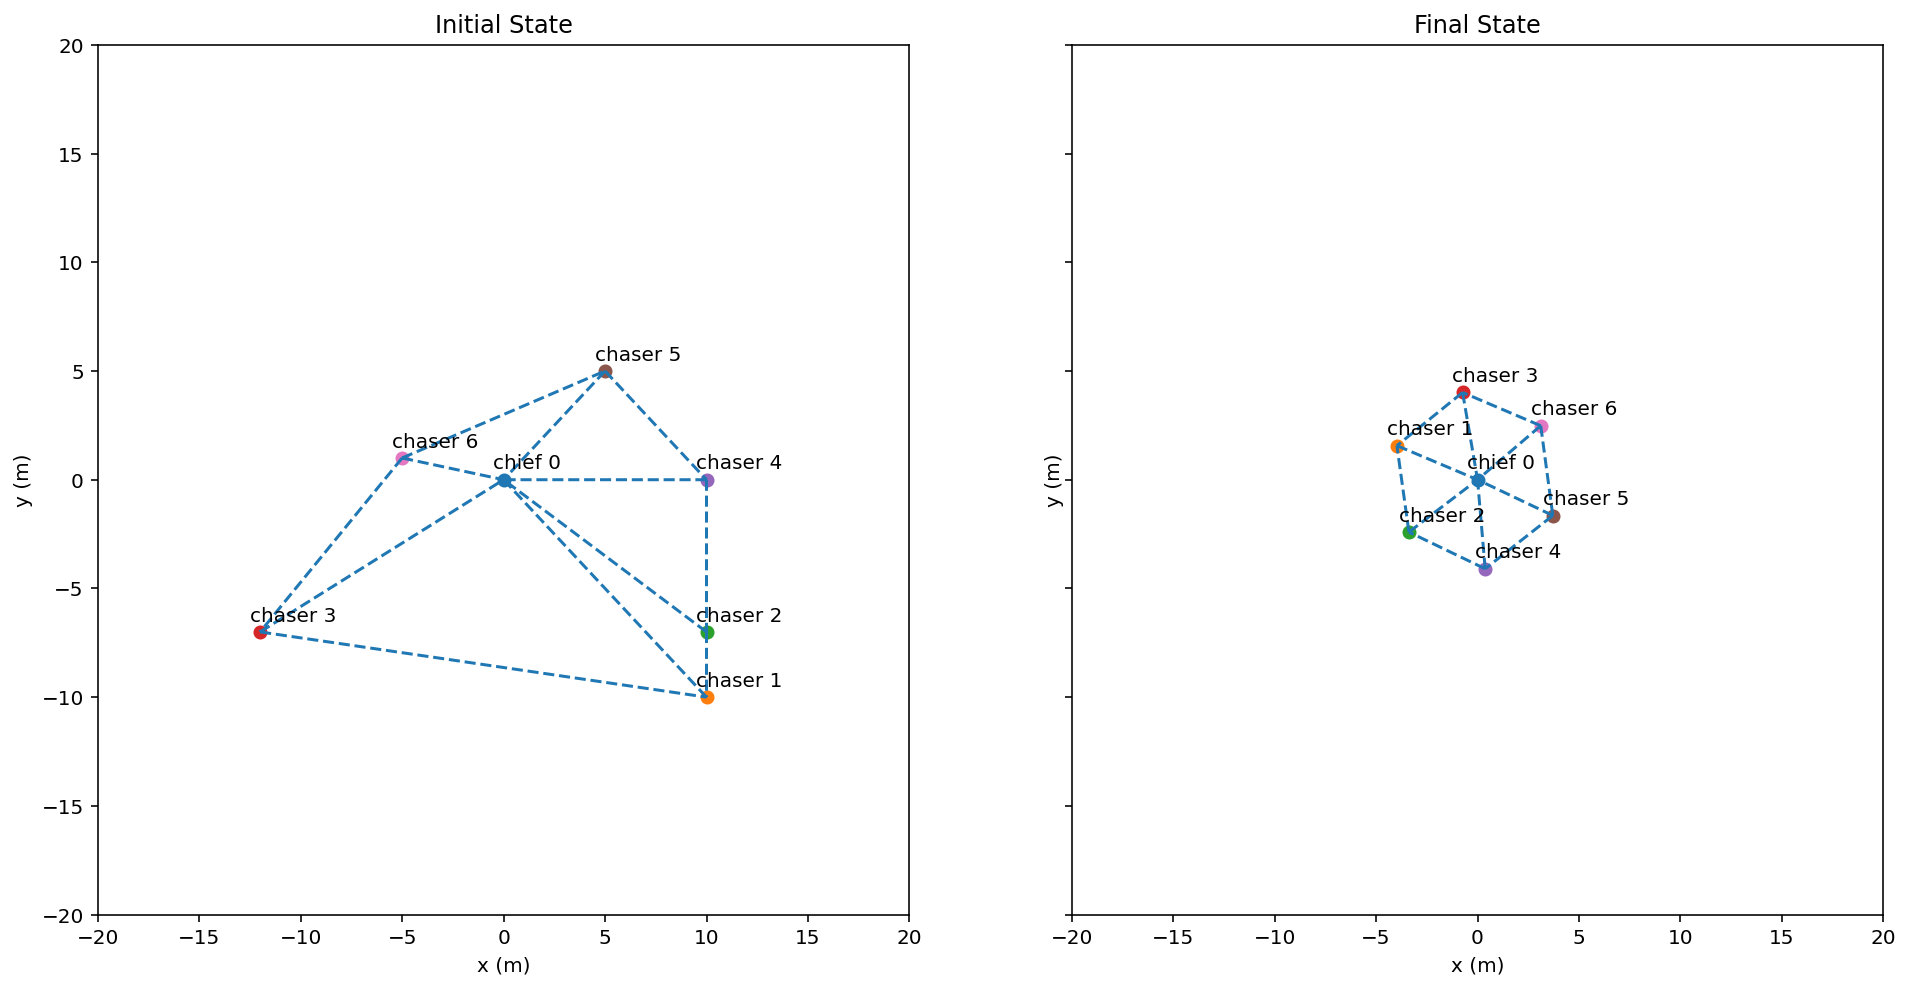

In [6]:
# create a plot of initial and final state
def plot_satellites(ax, sats, use_tri=True):
    ax.set_xlim([-20, 20])
    ax.set_ylim([-20, 20])
    points = np.array([(0, 0)] + [s[:2] for s in sats])
    for idx, p in enumerate(points):
        ax.scatter(*p)
        ax.text(p[0]-0.5, p[1]+0.5, f"{'chief ' if idx == 0 else 'chaser '}{idx}")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    if use_tri:
        tri = Delaunay(points)
        ax.triplot(points[:,0], points[:,1], tri.simplices, '--')

fig, ax = plt.subplots(figsize=(16, 8), ncols=2, sharey=True, sharex=True)
plot_satellites(ax[0], [s[0, :] for s in states])
plot_satellites(ax[1], [s[-1, :] for s in states])
ax[0].set_title("Initial State")
ax[1].set_title("Final State")
plt.show()

## Animation

When running the Jupyter notebook, animation is available to view the trajectories as a movie. Uncomment the following code and run.

In [7]:
# uncomment this to get an animation of the satellites
"""
%matplotlib notebook
ani = canm.plot_sats_anim(states)
from IPython.display import HTML
HTML(ani.to_jshtml())
"""

'\n%matplotlib notebook\nani = canm.plot_sats_anim(states)\nfrom IPython.display import HTML\nHTML(ani.to_jshtml())\n'